In [35]:
from pandas import Series, DataFrame
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFE,RFECV
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV,cross_validate
from sklearn import metrics
import numpy as np

from sklearn.metrics import r2_score,mean_squared_error

%matplotlib inline

In [2]:
df = pd.read_csv('bigmart_train.csv')

## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ProductID          8523 non-null   object 
 1   Weight             7060 non-null   float64
 2   FatContent         8523 non-null   object 
 3   ProductVisibility  8523 non-null   float64
 4   ProductType        8523 non-null   object 
 5   MRP                8523 non-null   float64
 6   OutletID           8523 non-null   object 
 7   EstablishmentYear  8523 non-null   int64  
 8   OutletSize         6113 non-null   object 
 9   LocationType       8523 non-null   object 
 10  OutletType         8523 non-null   object 
 11  OutletSales        8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [4]:
df.describe()

,Weight,ProductVisibility,MRP,EstablishmentYear,OutletSales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [5]:
#null check
df.isnull().sum()

ProductID               0
Weight               1463
FatContent              0
ProductVisibility       0
ProductType             0
MRP                     0
OutletID                0
EstablishmentYear       0
OutletSize           2410
LocationType            0
OutletType              0
OutletSales             0
dtype: int64

C:\Users\anuka\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\anuka\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\anuka\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


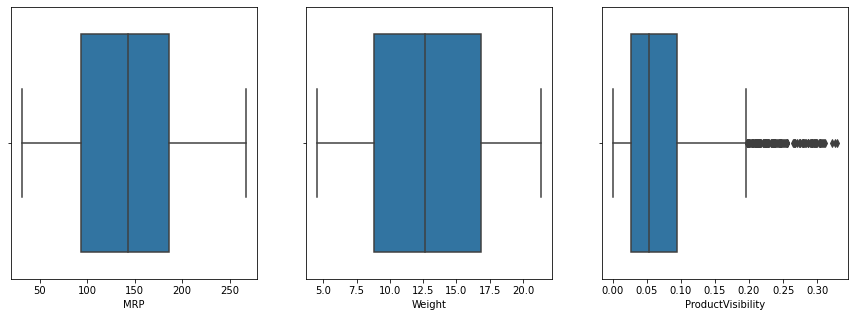

In [6]:
#Detecting outliers :
fig, axis = plt.subplots(nrows=1, ncols=3,figsize=(15,5))
X = df[['MRP', 'Weight','ProductVisibility']]
for i,column in enumerate(X):
    sns.boxplot(df[column],ax=axis[i])
    
import warnings
warnings.filterwarnings('ignore')

#### Check for skewness 

<AxesSubplot:xlabel='OutletSales', ylabel='Density'>

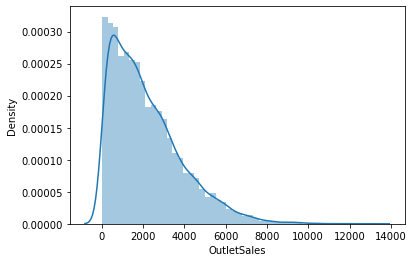

In [7]:
df.skew().sort_values(ascending=False)
sns.distplot(df['OutletSales'])

OutletSales          1.177531
ProductVisibility    1.167091
MRP                  0.127202
Weight               0.082426
EstablishmentYear   -0.396641
outletSales_log     -0.887753
dtype: float64

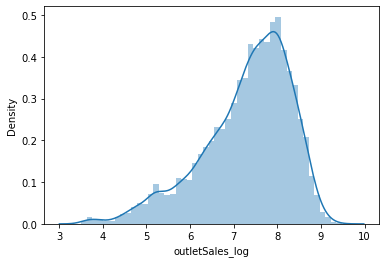

In [8]:
#log transformation
df['outletSales_log']=np.log(df['OutletSales'])
sns.distplot(df['outletSales_log'])
df.skew().sort_values(ascending=False)

Square root Transformation

OutletSales          1.177531
ProductVisibility    1.167091
outletSales_sqrt     0.234676
MRP                  0.127202
Weight               0.082426
EstablishmentYear   -0.396641
outletSales_log     -0.887753
dtype: float64

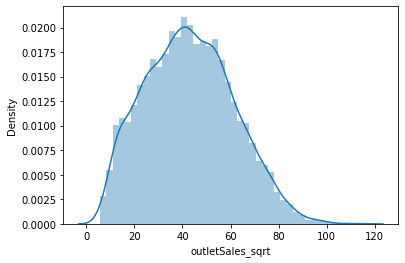

In [9]:
#SQRT transformation
import warnings
warnings.filterwarnings('ignore')

df['outletSales_sqrt'] = np.sqrt(df['OutletSales'])
sns.distplot(df['outletSales_sqrt'])
df.skew().sort_values(ascending=False)

# we see that sqrt transform works better in our favour (-0.5 to 0.5)

OutletSales           1.177531
ProductVisibility     1.167091
outletSales_sqrt      0.234676
MRP                   0.127202
Weight                0.082426
outletSales_boxcox   -0.074978
EstablishmentYear    -0.396641
outletSales_log      -0.887753
dtype: float64

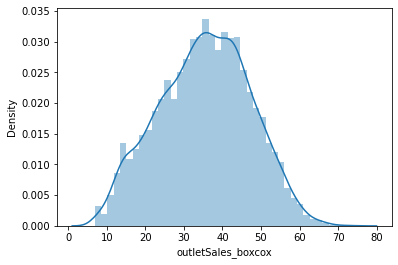

In [10]:
#boxcox method
from scipy import stats

df['outletSales_boxcox']=stats.boxcox(df['OutletSales'])[0]
sns.distplot(df['outletSales_boxcox'])
df.skew().sort_values(ascending=False)
#observation - boxcox gives the most normal distribution

ProductVisibility     1.231434
OutletSales           1.172910
prodvis_sqrt          0.409778
outletSales_sqrt      0.233076
MRP                   0.122910
Weight                0.079220
outletSales_boxcox   -0.075036
EstablishmentYear    -0.397468
outletSales_log      -0.880156
dtype: float64

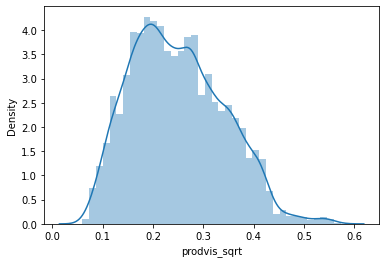

In [11]:
# SQRT transformation for prod vis
import warnings
warnings.filterwarnings('ignore')

df_new = df[df['ProductVisibility'] !=0]

df_new['prodvis_sqrt'] = np.sqrt(df_new['ProductVisibility'])
sns.distplot(df_new['prodvis_sqrt'])
df_new.skew().sort_values(ascending=False)


# sns.distplot(stats.boxcox(df['ProductVisibility'])[0])  
#--doesn't work due to min value 0, data must be positive

# sns.distplot(np.log(df['ProductVisibility']))
# OverflowError: cannot convert float infinity to integer


In [12]:
df_new.describe()

,Weight,ProductVisibility,MRP,EstablishmentYear,OutletSales,outletSales_log,outletSales_sqrt,outletSales_boxcox,prodvis_sqrt
count,6624.000000,7997.000000,7997.000000,7997.000000,7997.000000,7997.000000,7997.000000,7997.000000,7997.000000
mean,12.876462,0.070482,141.181925,1997.826185,2178.575445,7.295076,42.915259,35.341054,0.249081
std,4.644317,0.050308,62.201545,8.364645,1704.227930,1.016899,18.354784,11.825706,0.091877
min,4.555000,0.003575,31.290000,1985.000000,33.290000,3.505257,5.769749,6.836187,0.059789
25%,8.785000,0.031403,94.109400,1987.000000,829.586800,6.720928,28.802548,26.737900,0.177210
50%,12.600000,0.057792,143.215400,1999.000000,1794.331000,7.492388,42.359544,35.815426,0.240400
75%,16.850000,0.098109,185.758200,2004.000000,3098.633200,8.038716,55.665368,43.880540,0.313223
max,21.350000,0.328391,266.888400,2009.000000,13086.964800,9.479372,114.398273,74.153973,0.573054


### Data preprocessing based on EDA

In [13]:
# Null handling
df_new['Weight']=df_new['Weight'].fillna(12.857645) 
df_new['OutletSize']=df_new['OutletSize'].fillna('Medium')

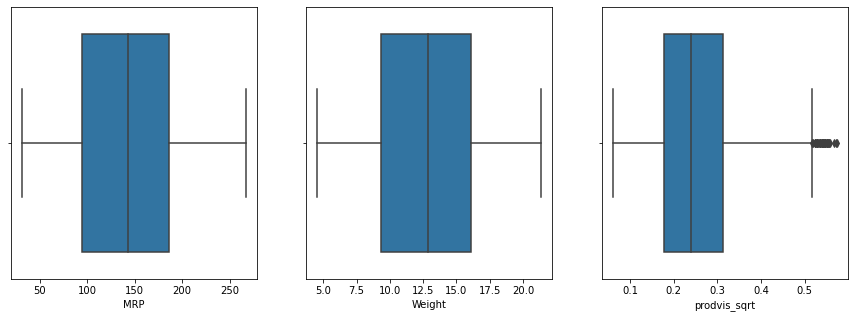

In [14]:
#Detecting outliers :
fig, axis = plt.subplots(nrows=1, ncols=3,figsize=(15,5))
X = df_new[['MRP', 'Weight','prodvis_sqrt']]
for i,column in enumerate(X):
    sns.boxplot(df_new[column],ax=axis[i])
    
import warnings
warnings.filterwarnings('ignore')

In [15]:
#Filtering out the outliers

df_filtered = df_new[df_new['prodvis_sqrt']<=0.57]
df_filtered

,ProductID,Weight,FatContent,ProductVisibility,ProductType,MRP,OutletID,EstablishmentYear,OutletSize,LocationType,OutletType,OutletSales,outletSales_log,outletSales_sqrt,outletSales_boxcox,prodvis_sqrt
0,FDA15,9.300000,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,8.225540,61.115775,47.007885,0.126678
1,DRC01,5.920000,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,6.094524,21.057607,20.958294,0.138846
2,FDN15,17.500000,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,7.648392,45.795961,37.964893,0.129461
6,FDO10,13.650000,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528,5.839341,18.535177,18.940593,0.112876
7,FDP10,12.857645,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636,8.299724,63.425260,48.306947,0.357029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865000,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834,7.929625,52.710373,42.145847,0.238293
8519,FDS36,8.380000,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,Medium,Tier 2,Supermarket Type1,549.2850,6.308617,23.436830,22.794301,0.216754
8520,NCJ29,10.600000,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136,7.084322,34.541477,30.712790,0.187580
8521,FDN46,7.210000,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976,7.520558,42.960419,36.195026,0.381078


array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

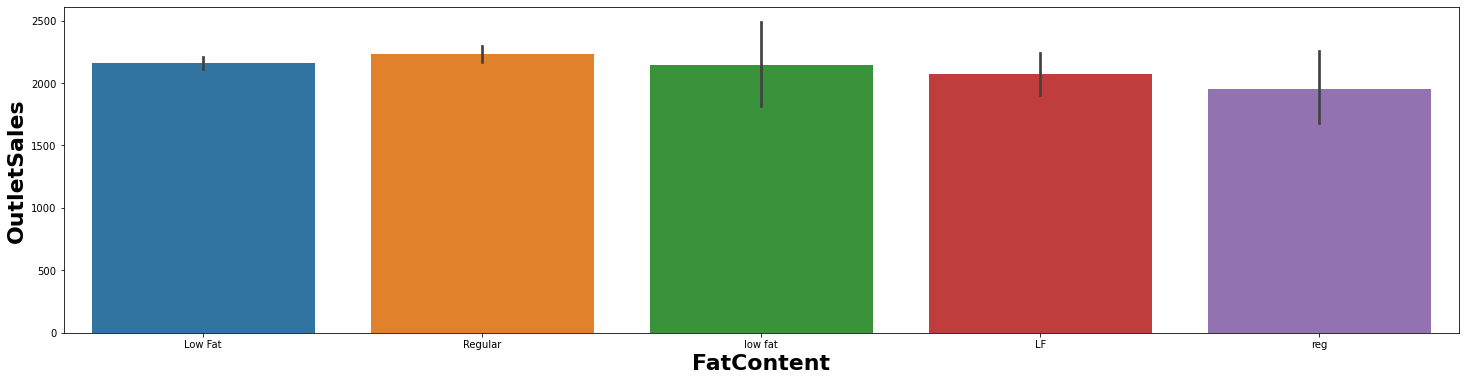

In [16]:
plt.figure(figsize=(25,6))
bar = sns.barplot(x=df_filtered['FatContent'] , y = df_filtered['OutletSales'])
bar.set_xlabel('FatContent',fontsize = 22,weight = 'bold' )
bar.set_ylabel('OutletSales',fontsize = 22,weight = 'bold')
df_filtered['FatContent'].unique()


In [17]:
def encodeFatContent(x):
    if(x in ('Low Fat', 'low fat', 'LF')):
        return 'Low Fat'
    else:
        return 'Regular'
df_filtered['FatContent'] = df_filtered['FatContent'].map(encodeFatContent)
df_filtered

,ProductID,Weight,FatContent,ProductVisibility,ProductType,MRP,OutletID,EstablishmentYear,OutletSize,LocationType,OutletType,OutletSales,outletSales_log,outletSales_sqrt,outletSales_boxcox,prodvis_sqrt
0,FDA15,9.300000,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,8.225540,61.115775,47.007885,0.126678
1,DRC01,5.920000,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,6.094524,21.057607,20.958294,0.138846
2,FDN15,17.500000,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,7.648392,45.795961,37.964893,0.129461
6,FDO10,13.650000,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528,5.839341,18.535177,18.940593,0.112876
7,FDP10,12.857645,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636,8.299724,63.425260,48.306947,0.357029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865000,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834,7.929625,52.710373,42.145847,0.238293
8519,FDS36,8.380000,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,Medium,Tier 2,Supermarket Type1,549.2850,6.308617,23.436830,22.794301,0.216754
8520,NCJ29,10.600000,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136,7.084322,34.541477,30.712790,0.187580
8521,FDN46,7.210000,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976,7.520558,42.960419,36.195026,0.381078


array(['Low Fat', 'Regular'], dtype=object)

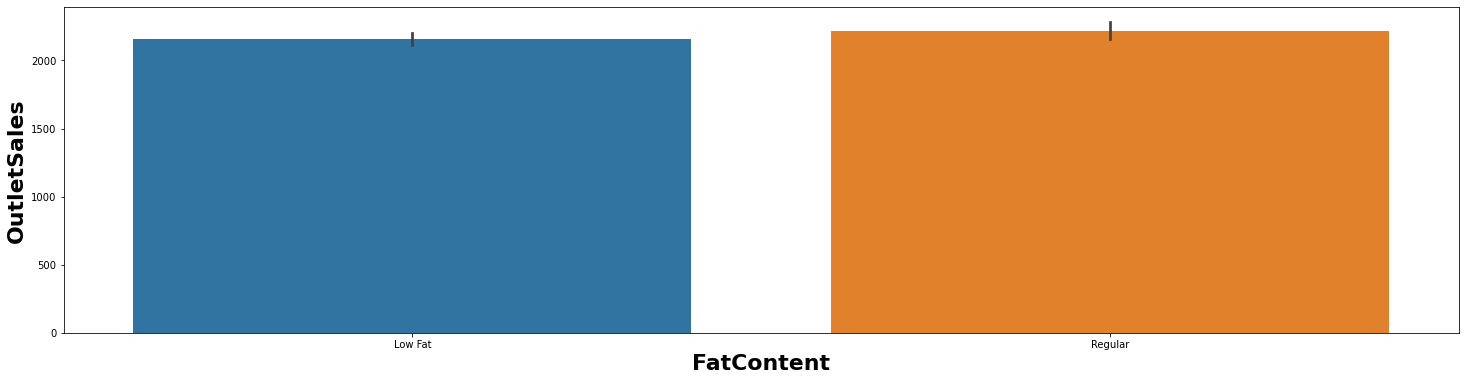

In [18]:
plt.figure(figsize=(25,6))
bar = sns.barplot(x=df_filtered['FatContent'] , y = df_filtered['OutletSales'])
bar.set_xlabel('FatContent',fontsize = 22,weight = 'bold' )
bar.set_ylabel('OutletSales',fontsize = 22,weight = 'bold')
df_filtered['FatContent'].unique()
#not much variation of outlet sales wrt fat content

Plotting Outlet sales per outlet type

In [19]:
# # Converting categorical variables 
# LowFat = ['Low Fat','LF','low fat']
# Regular = ['Regular','reg']

# def encodeFatContent(x):
#     return 1 if x in LowFat else 0
# df['fat_content'] = df['FatContent'].map(encodeFatContent)
# df


# df["product_type"] = df["ProductType"].astype('category')
# d = dict(enumerate(df["product_type"].cat.categories))
# print(d)
# df["product_type"] = df["product_type"].cat.codes
# # df.head()

# df.dtypes

# def outlettype(x):
#     if(x=='Supermarket Type1'):
#         return 1
#     elif(x=='Supermarket Type2'):
#         return 2
#     elif(x=='Supermarket Type3'):
#         return 3
#     else:
#         return 0
    
# def outletsize(x):
#     if(x=='Small'):
#         return 1
#     elif(x=='Medium'):
#         return 2
#     elif(x=='High'):
#         return 3
    
# df['outlet_type'] = df['OutletType'].map(outlettype)
# df['outlet_size'] = df['OutletSize'].map(outletsize)

# df

array(['Low Fat', 'Regular'], dtype=object)

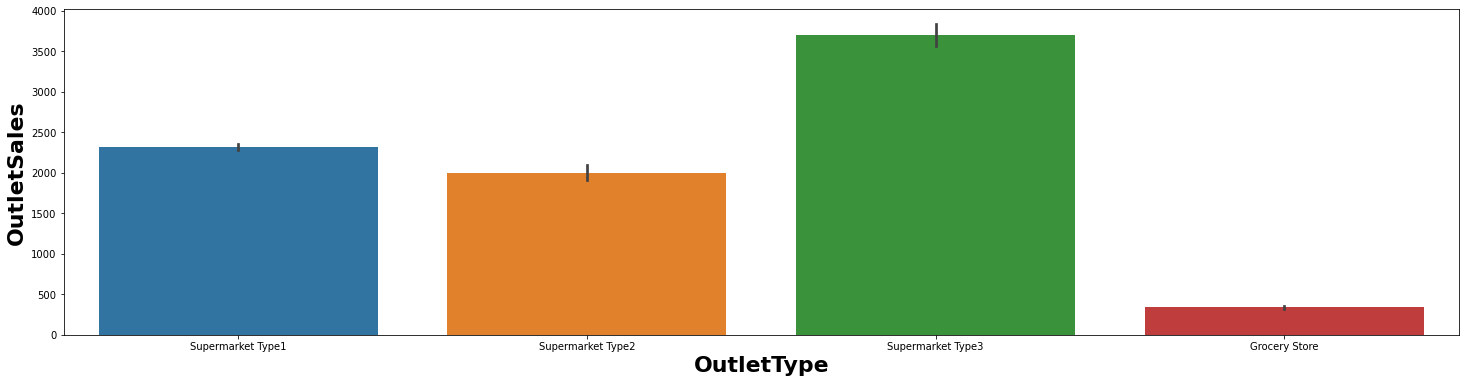

In [20]:
plt.figure(figsize=(25,6))
bar = sns.barplot(x=df_filtered['OutletType'] , y = df_filtered['OutletSales'])
bar.set_xlabel('OutletType',fontsize = 22,weight = 'bold' )
bar.set_ylabel('OutletSales',fontsize = 22,weight = 'bold')
df_filtered['FatContent'].unique()
# Super market type 3 has highest sales


In [21]:
# Perform one hot encoding for categorical variables

final_Df = pd.get_dummies(df_filtered, columns=['FatContent','ProductType','OutletSize','LocationType','OutletType'])
final_Df

,ProductID,Weight,ProductVisibility,MRP,OutletID,EstablishmentYear,OutletSales,outletSales_log,outletSales_sqrt,outletSales_boxcox,...,OutletSize_High,OutletSize_Medium,OutletSize_Small,LocationType_Tier 1,LocationType_Tier 2,LocationType_Tier 3,OutletType_Grocery Store,OutletType_Supermarket Type1,OutletType_Supermarket Type2,OutletType_Supermarket Type3
0,FDA15,9.300000,0.016047,249.8092,OUT049,1999,3735.1380,8.225540,61.115775,47.007885,...,0,1,0,1,0,0,0,1,0,0
1,DRC01,5.920000,0.019278,48.2692,OUT018,2009,443.4228,6.094524,21.057607,20.958294,...,0,1,0,0,0,1,0,0,1,0
2,FDN15,17.500000,0.016760,141.6180,OUT049,1999,2097.2700,7.648392,45.795961,37.964893,...,0,1,0,1,0,0,0,1,0,0
6,FDO10,13.650000,0.012741,57.6588,OUT013,1987,343.5528,5.839341,18.535177,18.940593,...,1,0,0,0,0,1,0,1,0,0
7,FDP10,12.857645,0.127470,107.7622,OUT027,1985,4022.7636,8.299724,63.425260,48.306947,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865000,0.056783,214.5218,OUT013,1987,2778.3834,7.929625,52.710373,42.145847,...,1,0,0,0,0,1,0,1,0,0
8519,FDS36,8.380000,0.046982,108.1570,OUT045,2002,549.2850,6.308617,23.436830,22.794301,...,0,1,0,0,1,0,0,1,0,0
8520,NCJ29,10.600000,0.035186,85.1224,OUT035,2004,1193.1136,7.084322,34.541477,30.712790,...,0,0,1,0,1,0,0,1,0,0
8521,FDN46,7.210000,0.145221,103.1332,OUT018,2009,1845.5976,7.520558,42.960419,36.195026,...,0,1,0,0,0,1,0,0,1,0


In [22]:
# # plt.scatter(df['OutletType'],df['OutletSize'], s=50, c=df['OutletSales'], cmap = 'YlOrRd')
# # plt.bar(df['OutletType'], height=0.4)
# from scipy import stats
# stats.spearmanr(df['outlet_type'],df['outlet_size'])

In [23]:
# #spearman for ranked categorical variables
# c = df[['product_type','fat_content','outlet_size','outlet_type','OutletSales']].corr(method = 'spearman')
# sns.heatmap(c, annot = True)
# plt.show()
# # print(c)

Text(0, 0.5, 'ProductVisibility')

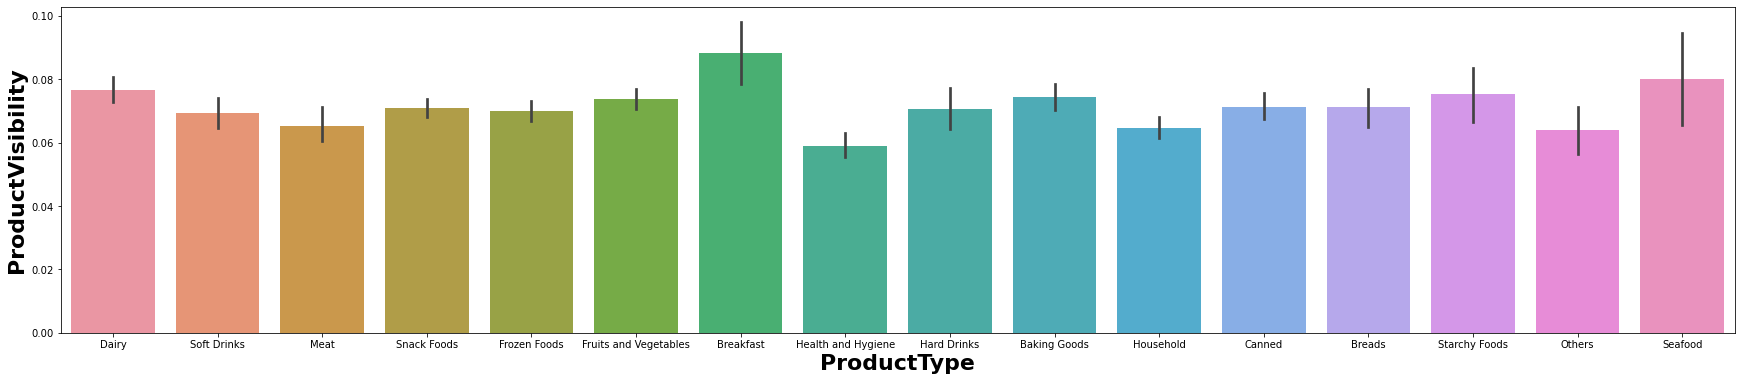

In [24]:
plt.figure(figsize=(30,6))
bar = sns.barplot(x=df_filtered['ProductType'] , y = df_filtered['ProductVisibility'])
bar.set_xlabel('ProductType',fontsize = 22,weight = 'bold' )
bar.set_ylabel('ProductVisibility',fontsize = 22,weight = 'bold')

Text(0, 0.5, 'OutletSales')

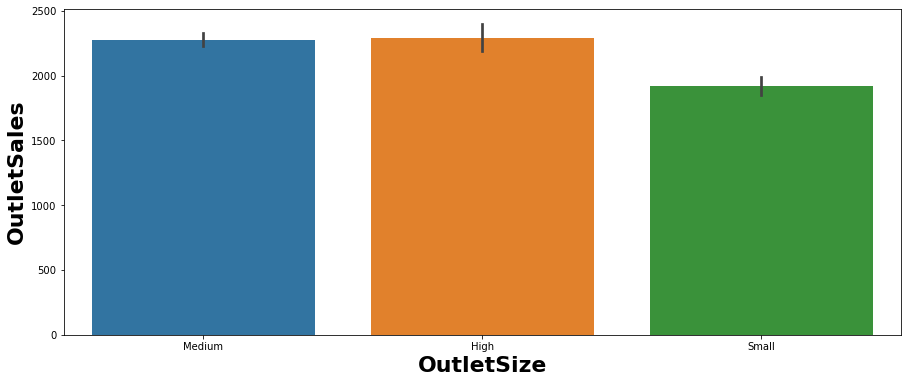

In [25]:
plt.figure(figsize=(15,6))
bar = sns.barplot(x=df_filtered['OutletSize'] , y = df_filtered['OutletSales'])
bar.set_xlabel('OutletSize',fontsize = 22,weight = 'bold' )
bar.set_ylabel('OutletSales',fontsize = 22,weight = 'bold')

<AxesSubplot:xlabel='OutletSize', ylabel='count'>

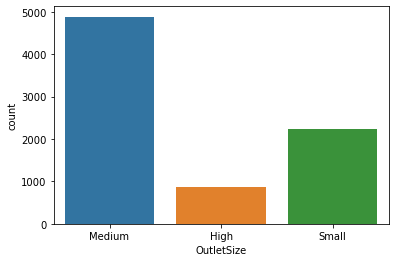

In [26]:
sns.countplot(x=df_filtered['OutletSize'])

In [27]:
# PLOT A PIE CHART to see sales vs outlet type
final_Df.columns

Index(['ProductID', 'Weight', 'ProductVisibility', 'MRP', 'OutletID',
       'EstablishmentYear', 'OutletSales', 'outletSales_log',
       'outletSales_sqrt', 'outletSales_boxcox', 'prodvis_sqrt',
       'FatContent_Low Fat', 'FatContent_Regular', 'ProductType_Baking Goods',
       'ProductType_Breads', 'ProductType_Breakfast', 'ProductType_Canned',
       'ProductType_Dairy', 'ProductType_Frozen Foods',
       'ProductType_Fruits and Vegetables', 'ProductType_Hard Drinks',
       'ProductType_Health and Hygiene', 'ProductType_Household',
       'ProductType_Meat', 'ProductType_Others', 'ProductType_Seafood',
       'ProductType_Snack Foods', 'ProductType_Soft Drinks',
       'ProductType_Starchy Foods', 'OutletSize_High', 'OutletSize_Medium',
       'OutletSize_Small', 'LocationType_Tier 1', 'LocationType_Tier 2',
       'LocationType_Tier 3', 'OutletType_Grocery Store',
       'OutletType_Supermarket Type1', 'OutletType_Supermarket Type2',
       'OutletType_Supermarket Type3'],
    

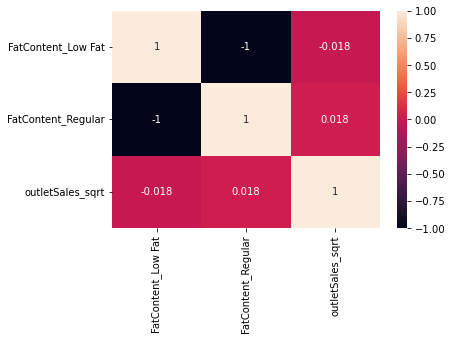

In [28]:
sns.heatmap(final_Df[['FatContent_Low Fat', 'FatContent_Regular','outletSales_sqrt']].corr(), annot = True)
plt.show()

<AxesSubplot:>

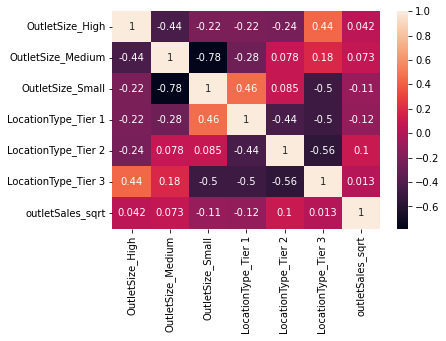

In [29]:
sns.heatmap(final_Df[['OutletSize_High', 'OutletSize_Medium',
       'OutletSize_Small','LocationType_Tier 1', 'LocationType_Tier 2',
       'LocationType_Tier 3','outletSales_sqrt']].corr(), annot = True)

#high correlation observed between OutletSize_High and LocationType_Tier3
#high correlation observed between OutletSize_Small and LocationType_Tier1 

## Train test split

In [63]:
feat = [ 'Weight', 'MRP','EstablishmentYear', 'prodvis_sqrt',
        'FatContent_Low Fat', 'FatContent_Regular', 'OutletSize_High', 'OutletSize_Medium',
       'OutletSize_Small', 'LocationType_Tier 2', 'OutletType_Grocery Store',
       'OutletType_Supermarket Type1', 'OutletType_Supermarket Type2',
       'OutletType_Supermarket Type3']
# 'LocationType_Tier 1',  'LocationType_Tier 3', --removed due to high correlation
df_X = final_Df[feat]
df_Y = final_Df['outletSales_sqrt']


In [64]:
X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y, test_size=0.20, random_state = 420)

In [65]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
fit = scaler.fit(df_X) #computes min/max to fit data
fitted_X_train = fit.transform(X_train)
fitted_X_test = fit.transform(X_test)

In [66]:
model = LinearRegression().fit(X_train, Y_train)
Y_pred = model.predict(X_train)

print('Model Accuracy on train data:',r2_score(Y_train,Y_pred)) 
print('Mean Squared Error:', mean_squared_error(Y_train, Y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_train, Y_pred)))


Model Accuracy on train data: 0.6512625944476902
Mean Squared Error: 117.49465465343593
Root Mean Squared Error: 10.839495129084007


In [67]:
Y_pred_test = model.predict(X_test)
test_score = r2_score(Y_test,Y_pred_test)
print('Model accuracy on test data :',test_score)
print('Mean Squared Error on test dataset: %.2f' % mean_squared_error(Y_test,Y_pred_test))
print('Root Mean Squared Error on test dataset: %.2f' % np.sqrt(mean_squared_error(Y_test,Y_pred_test)))


Model accuracy on test data : 0.6779490244241084
Mean Squared Error on test dataset: 108.34
Root Mean Squared Error on test dataset: 10.41


Text(0.5, 1.0, 'Multiple Linear Regression')

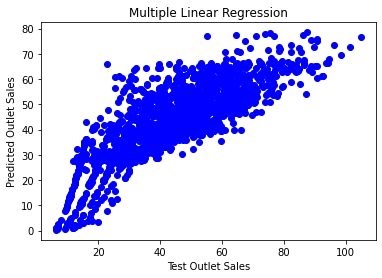

In [41]:
# Plot outputs
plt.scatter(Y_test, Y_pred_test, color="blue")
# sns.scatterplot(Y_pred_test, Y_test)
plt.xlabel('Test Outlet Sales')
plt.ylabel('Predicted Outlet Sales')
plt.title('Multiple Linear Regression')

In [56]:
# CHECK p values
import statsmodels.api as sm
from patsy import dmatrices
import matplotlib.pyplot as plt


X= df_X
y= df_Y
x2 = sm.add_constant(X)

# Creating a design matrices for running regression model
# y, X = dmatrices('avg_correctness ~ no_of_ratings', data=rater_goodness_df, return_type='dataframe')

# run Linear regression
model = sm.OLS(y, x2)       # Set up the model
result = model.fit()       # Fit model (find the intercept and slopes)
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       outletSales_sqrt   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     1388.
Date:                Sat, 06 Aug 2022   Prob (F-statistic):               0.00
Time:                        22:23:58   Log-Likelihood:                -30334.
No. Observations:                7995   AIC:                         6.069e+04
Df Residuals:                    7983   BIC:                         6.078e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [57]:
# Creating a design matrices for running regression model
y1, X1 = dmatrices('outletSales_sqrt ~ MRP', data=final_Df, return_type='dataframe')

# run Linear regression
model1 = sm.OLS(y1, X1)       # Set up the model
result1 = model1.fit()       # Fit model (find the intercept and slopes)
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:       outletSales_sqrt   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     3703.
Date:                Sat, 06 Aug 2022   Prob (F-statistic):               0.00
Time:                        22:33:14   Log-Likelihood:                -33087.
No. Observations:                7995   AIC:                         6.618e+04
Df Residuals:                    7993   BIC:                         6.619e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.4779      0.421     46.272      0.0

Text(0, 0.5, 'Outlet sales')

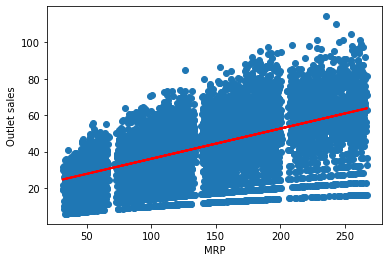

In [61]:
x = final_Df['MRP']
y = final_Df['outletSales_sqrt']
y_expected = result1.params['Intercept'] + result1.params['MRP']* x

plt.scatter(x = x, y = y)
plt.plot(x, y_expected, color = 'red', linewidth = 2, label = 'regression')
plt.xlabel('MRP')
plt.ylabel('Outlet sales')

Ridge regression

Ridge model accuracy :  0.6778935651315572


Text(0.5, 1.0, 'Ridge Regression')

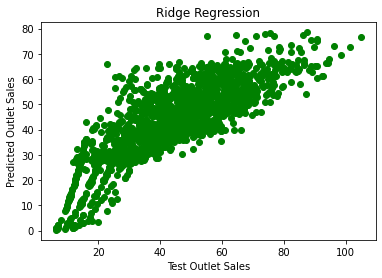

In [68]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, Y_train)
Y_pred_rd = ridge.predict(X_test)
print('Ridge model accuracy : ',r2_score(Y_test,Y_pred_rd))  # improves slightly

plt.scatter(Y_test, Y_pred_rd, color="green")
plt.xlabel('Test Outlet Sales')
plt.ylabel('Predicted Outlet Sales')
plt.title('Ridge Regression')

Lasso Regression:

Lasso model accuracy :  0.6060809450031587


array([ -0.        ,   0.16615512,  -0.18479758,  -0.        ,
        -0.        ,   0.        ,  -0.        ,   0.        ,
        -0.        ,   0.        , -21.25926039,   0.        ,
        -0.        ,   0.98054434])

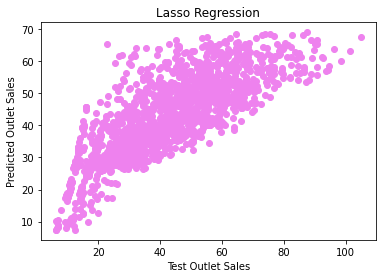

In [69]:
lasso = Lasso(alpha=1)
lasso.fit(X_train, Y_train)
Y_pred_ls = lasso.predict(X_test)
print('Lasso model accuracy : ',r2_score(Y_test,Y_pred_ls))

plt.scatter(Y_test, Y_pred_ls, color="violet")
plt.xlabel('Test Outlet Sales')
plt.ylabel('Predicted Outlet Sales')
plt.title('Lasso Regression')
lasso.coef_

#Lasso reduced accuracy to 60% by eliminating variables and keeping only 4

Random Forest Regression

In [47]:
print('Random Forest Regressor:')
rfmodel = RandomForestRegressor(n_estimators = 500, max_depth = 6 , max_features=12, random_state = 42)
# rfmodel = RandomForestRegressor(n_estimators = 500, max_depth = 6, max_features=12, random_state = 42) .696230

# max_features=5,max_depth=10, oob_score=True)        
#n_estimators = 1000, max_depth=6,random_state = 42 69.35
rfmodel.fit(X_train,Y_train)

Y_pred_test_rf = rfmodel.predict(X_test)
print('Accuracy:',r2_score(Y_test, Y_pred_test_rf))
print('Mean absolute error:', metrics.mean_absolute_error(Y_test,Y_pred_test_rf))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_test,Y_pred_test_rf)))

#print(rfr.estimators_)

import warnings
warnings.filterwarnings('ignore')

Random Forest Regressor:
Accuracy: 0.6950844044150883
Mean absolute error: 7.742532812795998
Root Mean Squared Error: 10.128121898964318


Text(0.5, 1.0, 'Random Forest Regression')

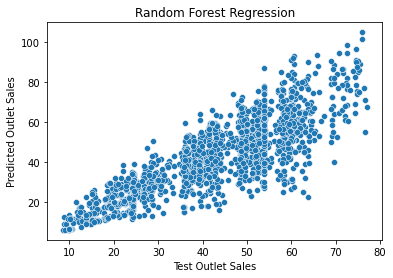

In [50]:
sns.scatterplot(Y_pred_test_rf, Y_test)
plt.xlabel('Test Outlet Sales')
plt.ylabel('Predicted Outlet Sales')
plt.title('Random Forest Regression')

### Cross validation on random forest

In [53]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 15, num = 19)]
max_depth.append(None)

# Method of selecting samples for training each tree
bootstrap = [True]

# Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]

# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 1, 2, 3, 4, 4, 5, 6, 7, 8, 8, 9, 10, 11, 11, 12, 13, 14, 15, None], 'bootstrap': [True]}


In [54]:
#Hyper tuning random forest------------
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='accuracy')
# Fit the random search model
rf_random.fit(df_X, df_Y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [1, 1, 2, 3, 4, 4, 5, 6, 7,
                                                      8, 8, 9, 10, 11, 11, 12,
                                                      13, 14, 15, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='accuracy', verbose=2)

In [55]:
rf_random.best_params_

{'n_estimators': 2000,
 'max_features': 'auto',
 'max_depth': 8,
 'bootstrap': True}

In [192]:
#RFE try
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=10, step=1)
x = rfe.fit(X_train, Y_train)

In [194]:
print(X_train.columns[rfe.support_])

Index(['Weight', 'MRP', 'EstablishmentYear', 'prodvis_sqrt',
       'FatContent_Low Fat', 'FatContent_Regular', 'OutletSize_Small',
       'LocationType_Tier 1', 'OutletType_Grocery Store',
       'OutletType_Supermarket Type3'],
      dtype='object')


In [197]:
forest = RandomForestRegressor()
_ = forest.fit(rfe.transform(X_train), Y_train)
forest.score(rfe.transform(X_test), Y_test)

0.6496944464091783

In [195]:
X_rfe = df_X.loc[:, rfe.support_]
# Xtest_rfe = X_test.loc[:, rfe.support_]
X_train_rfe, X_test_rfe, Y_train_rfe, Y_test_rfe = train_test_split(X_rfe, df_Y, test_size=0.20, random_state = 420)

In [230]:
# Cross validation

cv = cross_validate(rfmodel, X_train, Y_train, cv=7)
print(cv['test_score'])
print(cv['test_score'].mean())

[0.67118265 0.64497125 0.69018424 0.66645623 0.66972436 0.67437359
 0.66320769]
0.6685857168749744


---------------------------------------------------------------------------------

Gradient Boosting Model Accuracy: 0.6971252335095444
Mean Absolute Error: 7.731920563088675
Mean Squared Error: 101.89228317526928
Root Mean Squared Error: 10.094170752234643


Text(0.5, 1.0, 'Gradient Boosting Regression Model')

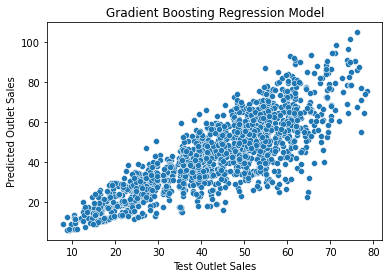

In [224]:
#Boosting

boostreg= GradientBoostingRegressor()
boostreg.fit(X_train,Y_train)
Y_pred_boost = boostreg.predict(X_test)

print('Gradient Boosting Model Accuracy:',r2_score(Y_test, Y_pred_boost))
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred_boost))
print('Mean Squared Error:', mean_squared_error(Y_test, Y_pred_boost))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_test, Y_pred_boost)))

sns.scatterplot(Y_pred_boost, Y_test)
plt.xlabel('Test Outlet Sales')
plt.ylabel('Predicted Outlet Sales')
plt.title('Gradient Boosting Regression Model')


[0.71828706 0.71204999 0.70333698 0.72097942]


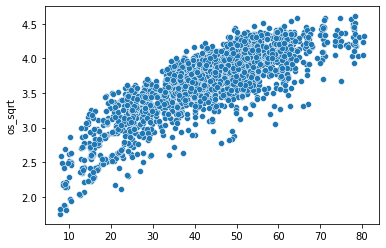

In [46]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(boostreg, X_train, np.log(Y_train), cv=4)
print(scores)
scores #---??
sns.scatterplot(Y_pred_boost, np.log(Y_test))

# plt.plot(X_plot, Y_plot, color='r')
import warnings
warnings.filterwarnings('ignore')